### Importación de código 

In [61]:
import cv2
from cv2 import WINDOW_NORMAL
from google.colab.patches import cv2_imshow
import numpy as np 
from matplotlib import pyplot as plt 
from skimage import exposure
from skimage import io
from skimage.exposure import is_low_contrast

Activar el uso de drive

In [62]:
# para activar el uso del drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importación de imágenes y transformación a escala de grises 


In [256]:
# importación de imágenes y conversión a grises
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/tarea_1_vision/flash_celular.jpeg', cv2.IMREAD_GRAYSCALE) # importación de figura 
img2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/tarea_1_vision/luz_natural.jpeg', cv2.IMREAD_GRAYSCALE) # importación de figura 
img3 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/tarea_1_vision/foco_blanco.jpeg', cv2.IMREAD_GRAYSCALE) # importación de figura  

def imagen(numero): 
  img_final = cv2.imread('/content/drive/MyDrive/Colab Notebooks/tarea_1_vision/prueba_' + str(numero) + '.jpg', cv2.IMREAD_GRAYSCALE) # importación de figura 
  return img_final

img_prueba = imagen(2)

Dsiminución de la resolución de las imágenes

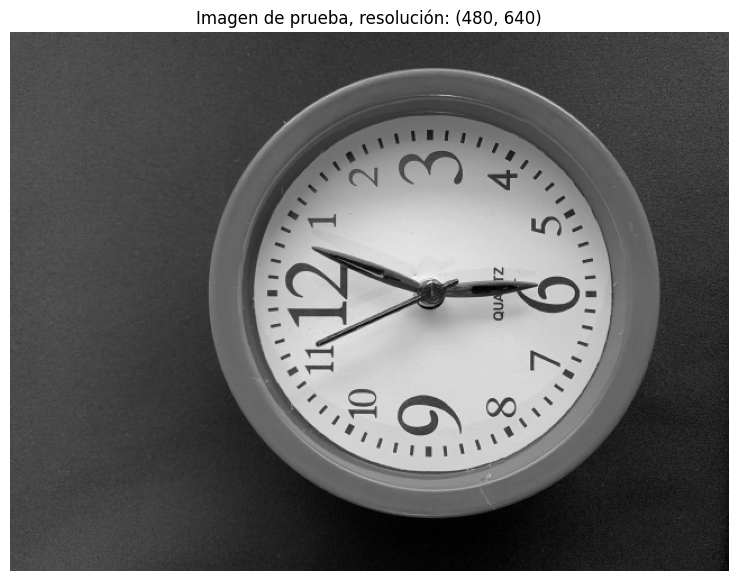

In [257]:
def resize(img, tamaño):
  scale_percent = tamaño # porcentaje al que se disminuirá la imagen
  width = int(img.shape[1] * scale_percent / 100) #nuevo ancho 
  height = int(img.shape[0] * scale_percent / 100) #nuevo alto 
  dim = (width, height) #nuevas dimensiones
    
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)


img = resize(img, 50)
img2 = resize(img2, 50)
img3 = resize(img3, 50)
img_prueba = resize(img_prueba, 50)

fig1 = plt.figure(figsize=(10, 7))
plt.imshow(img_prueba, cmap= "gray")
plt.title("Imagen de prueba, resolución: " + str(np.shape(img_prueba)))
plt.axis("off")
plt.show()

Mostrar las imágenes importadas y sus histogramas correspondientes

* Imágenes 1 y 2 

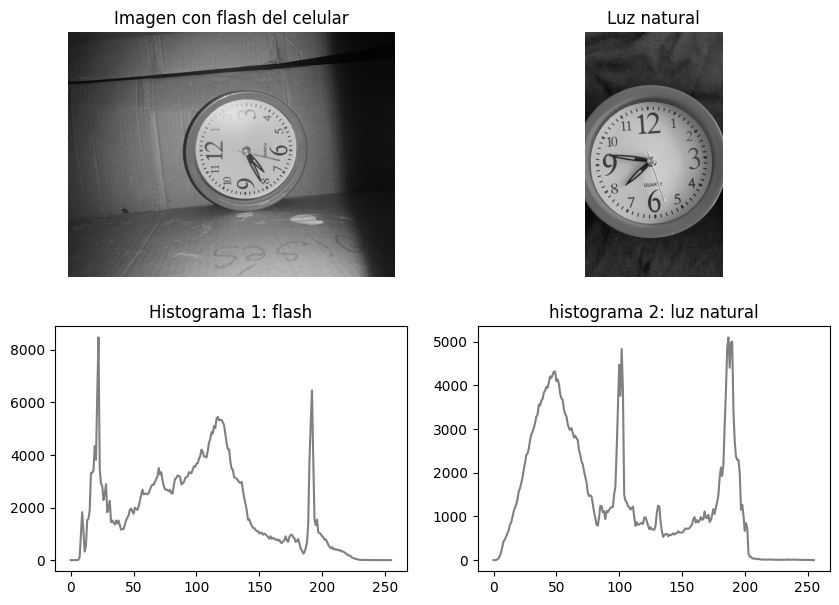

In [258]:
# Mostrar la imagen filtrad
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Imagen con flash del celular")

fig.add_subplot(2,2,2)
plt.imshow(img2, cmap= "gray")
plt.title("Luz natural")
plt.axis("off")

fig.add_subplot(2,2,3)
plt.plot(cv2.calcHist([img], [0], None, [256], [0, 256]), color ="gray")
plt.title("Histograma 1: flash")

fig.add_subplot(2,2,4)
plt.plot(cv2.calcHist([img2], [0], None, [256], [0, 256]), color = "gray")
plt.title("histograma 2: luz natural")
plt.show()


* Imagen 3

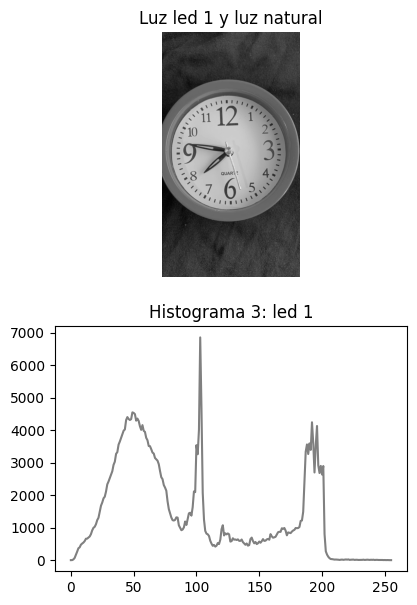

In [259]:
# Mostrar la imagen filtrada
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
plt.imshow(img3, cmap="gray")
plt.axis("off")
plt.title("Luz led 1 y luz natural")

fig.add_subplot(2,2,3)
plt.plot(cv2.calcHist([img3], [0], None, [256], [0, 256]), color ="gray")
plt.title("Histograma 3: led 1")
plt.show()

Binarización de la imagen

* Aplicar filtro de medianBlur para reducir el ruido

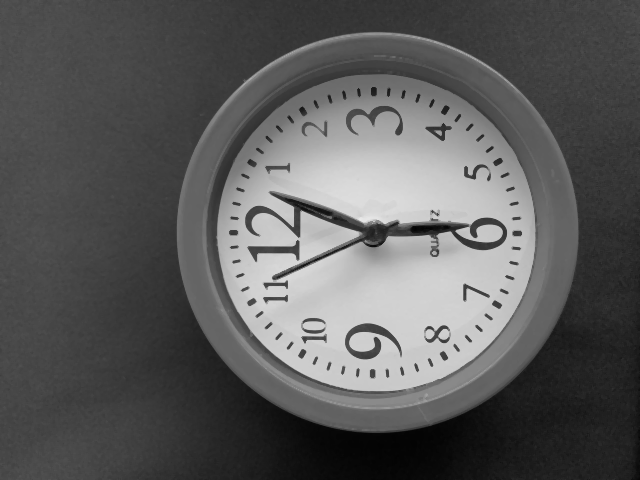

In [260]:
#aplicación del filtro
img_mod = cv2.medianBlur(img_prueba, 3)

#mostrar la imagen 
cv2_imshow(img_mod)
cv2.waitKey(0)
cv2.destroyAllWindows()

* Detectar circulos y generar máscara circular para aislar el área donde se encuentran las agujas del reloj. 

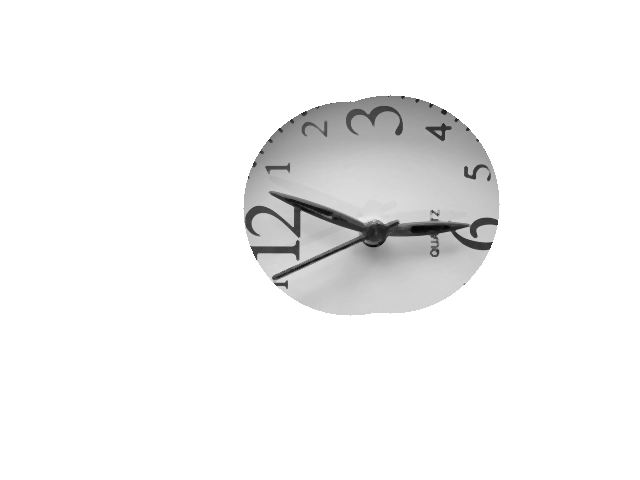

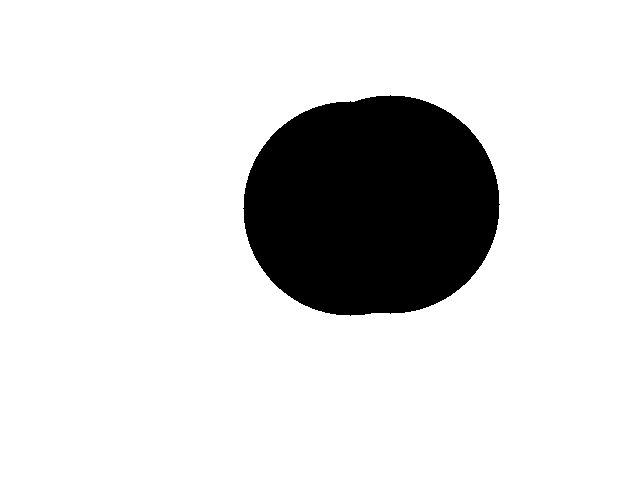

In [261]:

# Detectar los círculos en la imagen usando HoughCircles
circles = cv2.HoughCircles(img_mod, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=100, param2=40, minRadius=0, maxRadius=0)

# Convertir las coordenadas y el radio de los círculos a enteros
circles = np.uint16(np.around(circles))

# Crear una máscara de ceros del mismo tamaño que la imagen
mask = np.zeros((img_mod.shape[0], img_mod.shape[1]), dtype=np.uint8)
# Dibujar los círculos encontrados en la máscara
a=0
for i in circles[0,:]:
  if (i[2]>=150 and i[2]<=170 and a<=1):
    i[2] = i[2]*0.65
    cv2.circle(mask, (i[0], i[1]), i[2], 255, -1)
    a = a+1

# Aplicar la máscara a la imagen original
#masked_img = cv2.bitwise_and(img_mod, img_mod, mask=mask)

# Invertir la máscara
mask_inv = cv2.bitwise_not(mask)

# Pasar todo lo que esté afuera de la máscara a blanco
img_mod[mask_inv > 0] = 255

cv2_imshow(img_mod)
cv2_imshow(mask_inv)
cv2.waitKey(0)
cv2.destroyAllWindows()


Binarización de la imagen 

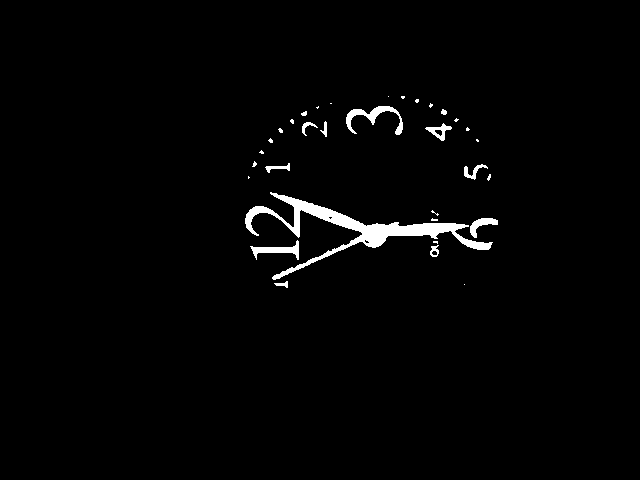

In [262]:
# Umbralización de la imagen con el método binario. 
ret, th = cv2.threshold(img_mod, 110, 255, cv2.THRESH_BINARY)

# Inversión de tonos blancos y negros

th = cv2.bitwise_not(th) 


# mostrar la imagen invertida
cv2_imshow(th) 
cv2.waitKey(0)
cv2.destroyAllWindows()

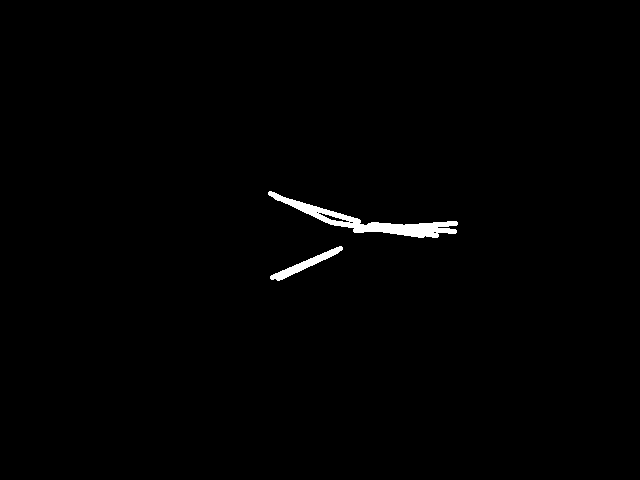

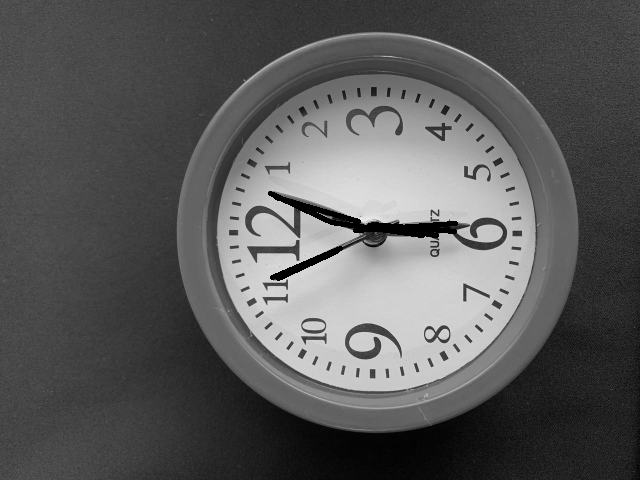

In [263]:
lines = cv2.HoughLinesP(th, 1, np.pi / 180, 10, minLineLength=50, maxLineGap=2)

# 4. Dibujar las líneas detectadas
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

# 5. Crear una máscara a partir de las líneas detectadas
mask = np.zeros_like(img_prueba)
for line in lines:
  x1, y1, x2, y2 = line[0]
  longitud = np.sqrt(np.square(x2-x1) + np.square(y2-y1))
  if(longitud>60):
    cv2.line(mask, (x1, y1), (x2, y2), 255, 2)

# 6. Aplicar la máscara a la imagen original
filtro_agujas = cv2.dilate(mask, None, iterations=1)

img_prueba[filtro_agujas > 0 ] = 0

# Mostrar el resultado final
cv2_imshow(filtro_agujas)
cv2_imshow(img_prueba)
cv2.waitKey(0)
cv2.destroyAllWindows()